# Model Performance Analysis - Parameter Impact Monitor

Notebook này sẽ tự động load tất cả các file report và phân tích:
1. Sự thay đổi parameters ảnh hưởng đến accuracy
2. So sánh performance giữa các lần chạy
3. Tìm ra configuration tối ưu
4. Giám sát xu hướng thay đổi theo thời gian

## 1. Import Required Libraries

In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Auto-Load All Report Files

In [13]:
def load_all_reports(reports_dir="../src/reports/"):
    """
    Tự động load tất cả các file JSON report từ thư mục reports
    """
    # Tìm tất cả file JSON trong thư mục reports
    json_files = glob.glob(os.path.join(reports_dir, "*.json"))
    
    reports_data = []
    
    print(f"🔍 Found {len(json_files)} report files:")
    
    for file_path in sorted(json_files):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Extract filename for identification
            filename = os.path.basename(file_path)
            
            # Add metadata
            data['file_info'] = {
                'filename': filename,
                'filepath': file_path
            }
            
            reports_data.append(data)
            print(f"  ✅ {filename}")
            
        except Exception as e:
            print(f"  ❌ Error loading {file_path}: {e}")
    
    print(f"\n📊 Successfully loaded {len(reports_data)} reports")
    return reports_data

# Load all reports
all_reports = load_all_reports()

🔍 Found 11 report files:
  ✅ accuracy_optimized_configuration_results_20250819_042440.json
  ✅ balanced_configuration_results_20250819_024601.json
  ✅ balanced_configuration_results_20250819_024930.json
  ✅ balanced_configuration_results_20250819_030058.json
  ✅ balanced_configuration_results_20250819_030303.json
  ✅ balanced_configuration_results_20250819_030547.json
  ✅ balanced_configuration_results_20250819_030912.json
  ✅ balanced_configuration_results_20250819_031300.json
  ✅ balanced_configuration_results_20250819_031626.json
  ✅ balanced_configuration_results_20250819_031916.json
  ✅ balanced_configuration_results_20250819_032241.json

📊 Successfully loaded 11 reports


## 3. Extract Performance and Parameter Data

In [14]:
def extract_comprehensive_data(reports_data):
    """
    Extract comprehensive data including parameters and performance metrics
    """
    comprehensive_data = []
    
    for report in reports_data:
        timestamp = report['training_summary']['timestamp']
        filename = report['file_info']['filename']
        
        # Extract training summary
        training_info = {
            'filename': filename,
            'timestamp': timestamp,
            'total_time_seconds': report['training_summary']['total_time_seconds'],
            'train_dataset_size': report['training_summary']['train_dataset_size'],
            'test_dataset_size': report['training_summary']['test_dataset_size']
        }
        
        # Extract model results with parameters
        for model_name, model_data in report['model_results'].items():
            row = training_info.copy()
            row.update({
                'model_type': model_name,
                'model_name_full': model_data['model_name'],
                
                # Performance metrics
                'train_accuracy': model_data['train_accuracy'],
                'test_accuracy': model_data['test_accuracy'],
                'overfitting_score': model_data['overfitting_score'],
                'f1_macro': model_data['f1_macro'],
                'f1_weighted': model_data['f1_weighted'],
                'training_time': model_data['training_time'],
                
                # TF-IDF Parameters
                'tfidf_max_features': model_data['tfidf_params']['max_features'],
                'tfidf_ngram_range': str(model_data['tfidf_params']['ngram_range']),
                'tfidf_min_df': model_data['tfidf_params']['min_df'],
                'tfidf_max_df': model_data['tfidf_params']['max_df'],
                'tfidf_sublinear_tf': model_data['tfidf_params']['sublinear_tf'],
            })
            
            # Model-specific parameters
            if model_name == 'logistic_regression':
                row.update({
                    'lr_C': model_data['model_params']['C'],
                    'lr_max_iter': model_data['model_params']['max_iter'],
                    'lr_solver': model_data['model_params']['solver']
                })
            elif model_name == 'random_forest':
                row.update({
                    'rf_n_estimators': model_data['model_params']['n_estimators'],
                    'rf_max_depth': model_data['model_params']['max_depth'],
                    'rf_min_samples_split': model_data['model_params']['min_samples_split'],
                    'rf_max_features': model_data['model_params']['max_features']
                })
            elif model_name == 'gradient_boosting':
                row.update({
                    'gb_n_estimators': model_data['model_params']['n_estimators'],
                    'gb_learning_rate': model_data['model_params']['learning_rate'],
                    'gb_max_depth': model_data['model_params']['max_depth'],
                    'gb_subsample': model_data['model_params']['subsample']
                })
            
            comprehensive_data.append(row)
    
    return pd.DataFrame(comprehensive_data)

# Extract all data
df_comprehensive = extract_comprehensive_data(all_reports)

print(f"📊 Extracted data shape: {df_comprehensive.shape}")
print(f"🔹 Models: {df_comprehensive['model_type'].unique()}")
print(f"🔹 Time range: {df_comprehensive['timestamp'].min()} to {df_comprehensive['timestamp'].max()}")

# Display first few rows
df_comprehensive.head()

📊 Extracted data shape: (33, 29)
🔹 Models: ['logistic_regression' 'random_forest' 'gradient_boosting']
🔹 Time range: 2025-08-19T02:46:01.106136 to 2025-08-19T04:24:40.924696


,filename,timestamp,total_time_seconds,train_dataset_size,test_dataset_size,model_type,model_name_full,train_accuracy,test_accuracy,overfitting_score,...,lr_max_iter,lr_solver,rf_n_estimators,rf_max_depth,rf_min_samples_split,rf_max_features,gb_n_estimators,gb_learning_rate,gb_max_depth,gb_subsample
0,accuracy_optimized_configuration_results_20250...,2025-08-19T04:24:40.924696,3490.65,500000,50000,logistic_regression,LogisticRegression,0.9404,0.9222,0.0183,...,2000.0,liblinear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,accuracy_optimized_configuration_results_20250...,2025-08-19T04:24:40.924696,3490.65,500000,50000,random_forest,RandomForestClassifier,0.8781,0.8526,0.0254,...,NaN,NaN,500.0,30.0,3.0,sqrt,NaN,NaN,NaN,NaN
2,accuracy_optimized_configuration_results_20250...,2025-08-19T04:24:40.924696,3490.65,500000,50000,gradient_boosting,GradientBoostingClassifier,0.8813,0.8753,0.0061,...,NaN,NaN,NaN,NaN,NaN,NaN,500.0,0.08,6.0,0.85
3,balanced_configuration_results_20250819_024601...,2025-08-19T02:46:01.106136,31.95,100000,30000,logistic_regression,LogisticRegression,0.9246,0.9026,0.0220,...,1500.0,liblinear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,balanced_configuration_results_20250819_024601...,2025-08-19T02:46:01.106136,31.95,100000,30000,random_forest,RandomForestClassifier,0.8642,0.8476,0.0166,...,NaN,NaN,150.0,20.0,5.0,log2,NaN,NaN,NaN,NaN


## 4. Parameter Impact Analysis

In [15]:
def analyze_parameter_impact(df):
    """
    Phân tích impact của từng parameter đến performance
    """
    print("🔍 PARAMETER IMPACT ANALYSIS")
    print("=" * 50)
    
    # 1. TF-IDF Parameters Impact
    print("\n📊 1. TF-IDF Parameters Impact:")
    tfidf_impact = df.groupby('tfidf_max_features').agg({
        'test_accuracy': ['mean', 'std', 'count'],
        'f1_macro': ['mean', 'std'],
        'overfitting_score': ['mean', 'std']
    }).round(4)
    
    print("\nImpact of max_features on performance:")
    print(tfidf_impact)
    
    # 2. Model-specific parameter analysis
    print("\n📊 2. Model-specific Parameter Analysis:")
    
    # Logistic Regression
    lr_data = df[df['model_type'] == 'logistic_regression']
    if not lr_data.empty:
        print("\n🔸 Logistic Regression - Impact of C parameter:")
        lr_impact = lr_data.groupby('lr_C').agg({
            'test_accuracy': 'mean',
            'overfitting_score': 'mean',
            'training_time': 'mean'
        }).round(4)
        print(lr_impact)
    
    # Random Forest
    rf_data = df[df['model_type'] == 'random_forest']
    if not rf_data.empty:
        print("\n🔸 Random Forest - Impact of n_estimators:")
        rf_impact = rf_data.groupby('rf_n_estimators').agg({
            'test_accuracy': 'mean',
            'overfitting_score': 'mean',
            'training_time': 'mean'
        }).round(4)
        print(rf_impact)
    
    # Gradient Boosting
    gb_data = df[df['model_type'] == 'gradient_boosting']
    if not gb_data.empty:
        print("\n🔸 Gradient Boosting - Impact of learning_rate:")
        gb_impact = gb_data.groupby('gb_learning_rate').agg({
            'test_accuracy': 'mean',
            'overfitting_score': 'mean',
            'training_time': 'mean'
        }).round(4)
        print(gb_impact)

analyze_parameter_impact(df_comprehensive)

🔍 PARAMETER IMPACT ANALYSIS

📊 1. TF-IDF Parameters Impact:

Impact of max_features on performance:
                   test_accuracy               f1_macro          \
                            mean     std count     mean     std   
tfidf_max_features                                                
2500                      0.8373  0.0000     2   0.8368  0.0000   
5000                      0.8552  0.0281     8   0.8547  0.0285   
8000                      0.8387     NaN     1   0.8380     NaN   
10000                     0.8462  0.0359     7   0.8454  0.0367   
15000                     0.8754  0.0352     4   0.8750  0.0354   
20000                     0.8475  0.0602     8   0.8463  0.0617   
30000                     0.9073  0.0000     2   0.9072  0.0000   
50000                     0.9222     NaN     1   0.9222     NaN   

                   overfitting_score          
                                mean     std  
tfidf_max_features                            
2500                 

## 5. Performance Trend Analysis

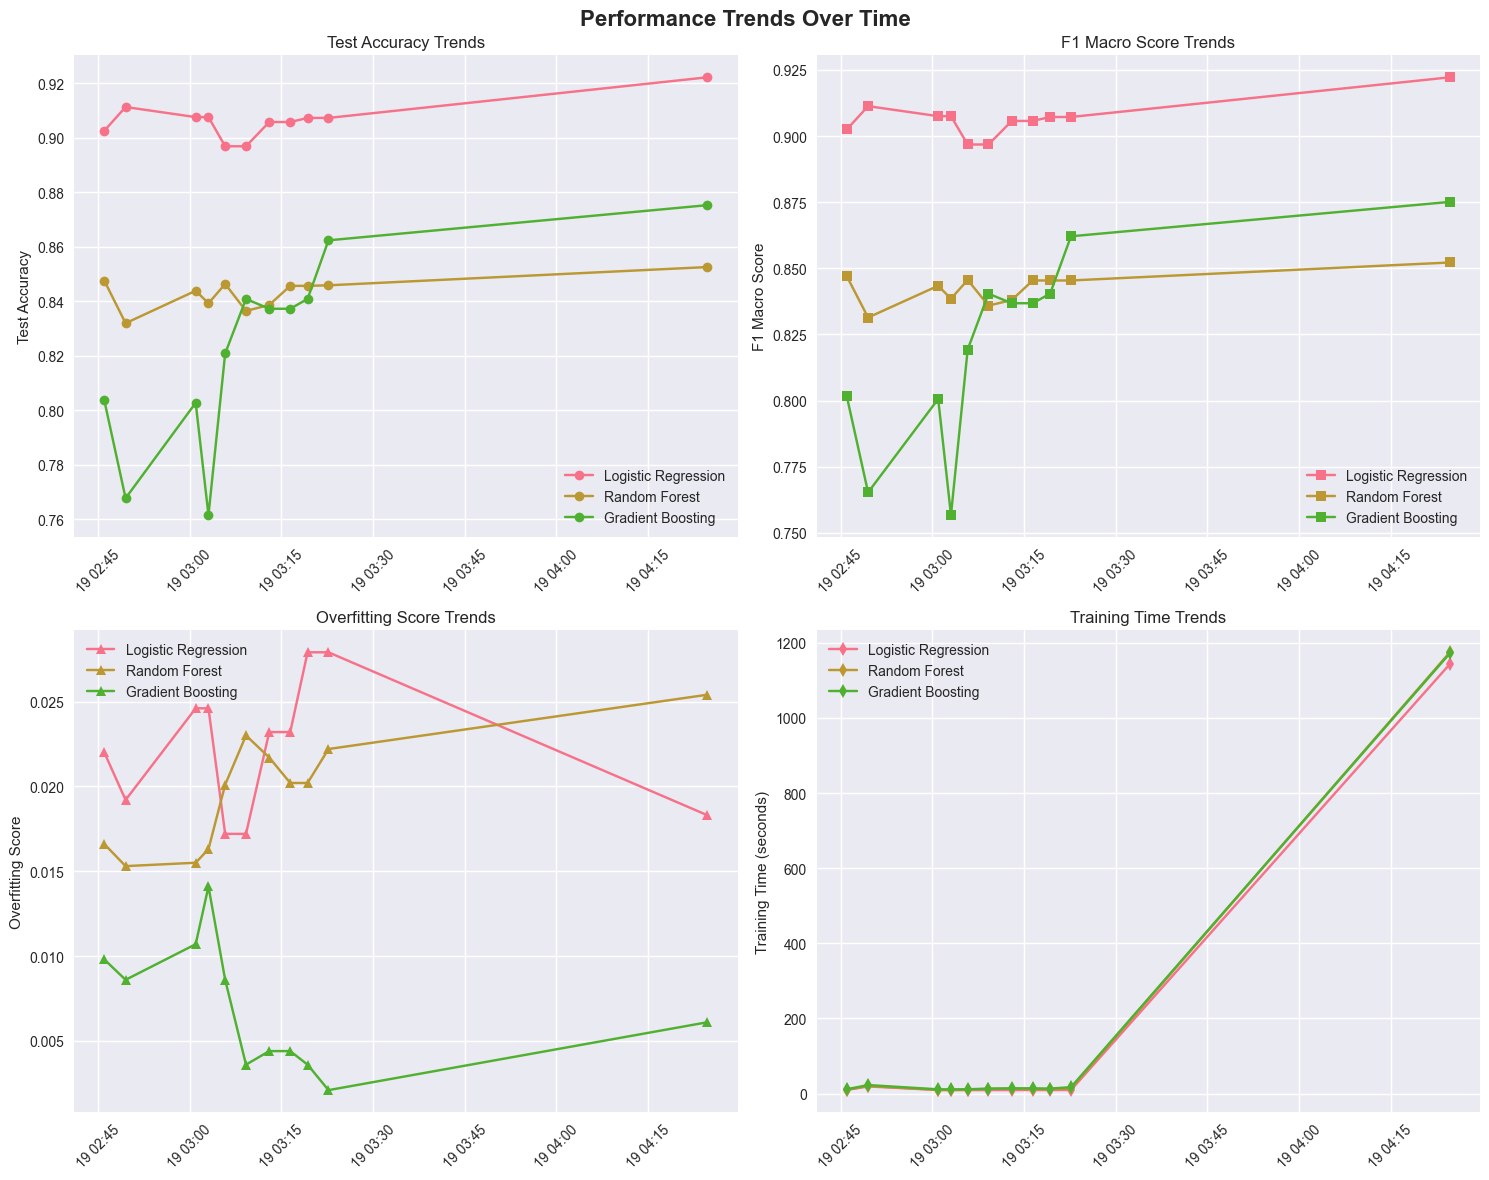

📈 Performance trends visualization completed!


In [5]:
# Convert timestamp to datetime for time series analysis
df_comprehensive['datetime'] = pd.to_datetime(df_comprehensive['timestamp'])
df_comprehensive = df_comprehensive.sort_values('datetime')

# Create time series plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance Trends Over Time', fontsize=16, fontweight='bold')

# 1. Test Accuracy over time
for model in df_comprehensive['model_type'].unique():
    model_data = df_comprehensive[df_comprehensive['model_type'] == model]
    axes[0,0].plot(model_data['datetime'], model_data['test_accuracy'], 
                   marker='o', label=model.replace('_', ' ').title())
axes[0,0].set_title('Test Accuracy Trends')
axes[0,0].set_ylabel('Test Accuracy')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# 2. F1 Score over time
for model in df_comprehensive['model_type'].unique():
    model_data = df_comprehensive[df_comprehensive['model_type'] == model]
    axes[0,1].plot(model_data['datetime'], model_data['f1_macro'], 
                   marker='s', label=model.replace('_', ' ').title())
axes[0,1].set_title('F1 Macro Score Trends')
axes[0,1].set_ylabel('F1 Macro Score')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Overfitting Score over time
for model in df_comprehensive['model_type'].unique():
    model_data = df_comprehensive[df_comprehensive['model_type'] == model]
    axes[1,0].plot(model_data['datetime'], model_data['overfitting_score'], 
                   marker='^', label=model.replace('_', ' ').title())
axes[1,0].set_title('Overfitting Score Trends')
axes[1,0].set_ylabel('Overfitting Score')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Training Time over time
for model in df_comprehensive['model_type'].unique():
    model_data = df_comprehensive[df_comprehensive['model_type'] == model]
    axes[1,1].plot(model_data['datetime'], model_data['training_time'], 
                   marker='d', label=model.replace('_', ' ').title())
axes[1,1].set_title('Training Time Trends')
axes[1,1].set_ylabel('Training Time (seconds)')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("📈 Performance trends visualization completed!")

## 6. Parameter vs Performance Correlation Analysis

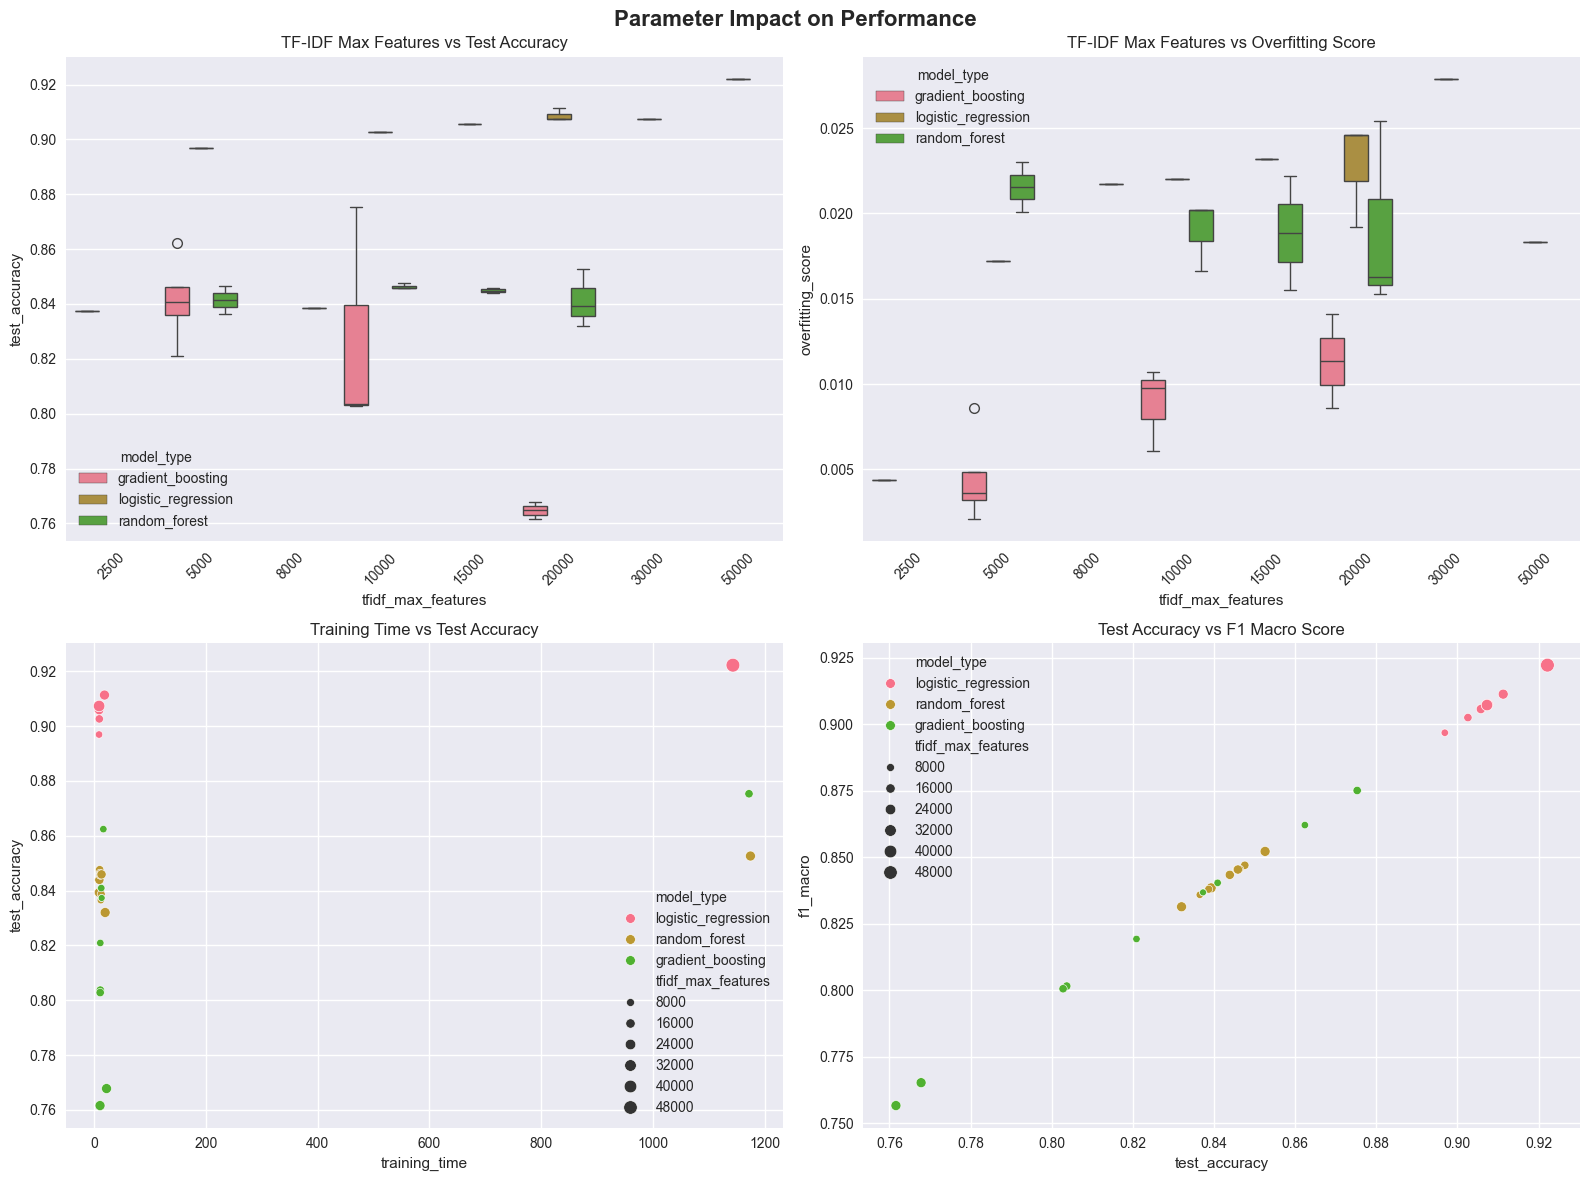

In [6]:
def plot_parameter_correlation(df):
    """
    Visualize correlation between parameters and performance
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Parameter Impact on Performance', fontsize=16, fontweight='bold')
    
    # 1. TF-IDF max_features vs Test Accuracy
    sns.boxplot(data=df, x='tfidf_max_features', y='test_accuracy', hue='model_type', ax=axes[0,0])
    axes[0,0].set_title('TF-IDF Max Features vs Test Accuracy')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. TF-IDF max_features vs Overfitting
    sns.boxplot(data=df, x='tfidf_max_features', y='overfitting_score', hue='model_type', ax=axes[0,1])
    axes[0,1].set_title('TF-IDF Max Features vs Overfitting Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Training Time vs Test Accuracy
    sns.scatterplot(data=df, x='training_time', y='test_accuracy', 
                   hue='model_type', size='tfidf_max_features', ax=axes[1,0])
    axes[1,0].set_title('Training Time vs Test Accuracy')
    
    # 4. Test Accuracy vs F1 Score
    sns.scatterplot(data=df, x='test_accuracy', y='f1_macro', 
                   hue='model_type', size='tfidf_max_features', ax=axes[1,1])
    axes[1,1].set_title('Test Accuracy vs F1 Macro Score')
    
    plt.tight_layout()
    plt.show()

plot_parameter_correlation(df_comprehensive)

## 7. Best Configuration Analysis

In [16]:
def find_best_configurations(df):
    """
    Tìm configuration tốt nhất cho mỗi model
    """
    print("🏆 BEST CONFIGURATIONS ANALYSIS")
    print("=" * 50)
    
    best_configs = {}
    
    for model_type in df['model_type'].unique():
        model_data = df[df['model_type'] == model_type]
        
        # Find best by test accuracy
        best_accuracy = model_data.loc[model_data['test_accuracy'].idxmax()]
        
        # Find best by F1 score
        best_f1 = model_data.loc[model_data['f1_macro'].idxmax()]
        
        # Find best balanced (accuracy - overfitting)
        model_data['balanced_score'] = model_data['test_accuracy'] - model_data['overfitting_score']
        best_balanced = model_data.loc[model_data['balanced_score'].idxmax()]
        
        best_configs[model_type] = {
            'best_accuracy': best_accuracy,
            'best_f1': best_f1,
            'best_balanced': best_balanced
        }
        
        print(f"\n🔸 {model_type.upper().replace('_', ' ')}:")
        print(f"   Best Accuracy: {best_accuracy['test_accuracy']:.4f} (Run: {best_accuracy['filename']})")
        print(f"   Best F1 Score: {best_f1['f1_macro']:.4f} (Run: {best_f1['filename']})")
        print(f"   Best Balanced: {best_balanced['balanced_score']:.4f} (Run: {best_balanced['filename']})")
        
        if model_type == 'logistic_regression':
            print(f"   → Best Config: C={best_accuracy['lr_C']}, max_features={best_accuracy['tfidf_max_features']}")
        elif model_type == 'random_forest':
            print(f"   → Best Config: n_estimators={best_accuracy['rf_n_estimators']}, max_depth={best_accuracy['rf_max_depth']}, max_features={best_accuracy['tfidf_max_features']}")
        elif model_type == 'gradient_boosting':
            print(f"   → Best Config: learning_rate={best_accuracy['gb_learning_rate']}, n_estimators={best_accuracy['gb_n_estimators']}, max_features={best_accuracy['tfidf_max_features']}")
    
    return best_configs

best_configs = find_best_configurations(df_comprehensive)

🏆 BEST CONFIGURATIONS ANALYSIS

🔸 LOGISTIC REGRESSION:
   Best Accuracy: 0.9222 (Run: accuracy_optimized_configuration_results_20250819_042440.json)
   Best F1 Score: 0.9222 (Run: accuracy_optimized_configuration_results_20250819_042440.json)
   Best Balanced: 0.9039 (Run: accuracy_optimized_configuration_results_20250819_042440.json)
   → Best Config: C=1.5, max_features=50000

🔸 RANDOM FOREST:
   Best Accuracy: 0.8526 (Run: accuracy_optimized_configuration_results_20250819_042440.json)
   Best F1 Score: 0.8522 (Run: accuracy_optimized_configuration_results_20250819_042440.json)
   Best Balanced: 0.8310 (Run: balanced_configuration_results_20250819_024601.json)
   → Best Config: n_estimators=500.0, max_depth=30.0, max_features=20000

🔸 GRADIENT BOOSTING:
   Best Accuracy: 0.8753 (Run: accuracy_optimized_configuration_results_20250819_042440.json)
   Best F1 Score: 0.8751 (Run: accuracy_optimized_configuration_results_20250819_042440.json)
   Best Balanced: 0.8692 (Run: accuracy_optimi

## 8. Parameter Stability Analysis

In [18]:
def analyze_parameter_stability(df):
    """
    Phân tích tính ổn định của các parameter settings
    """
    print("📊 PARAMETER STABILITY ANALYSIS")
    print("=" * 50)
    
    # Analyze TF-IDF parameter stability
    tfidf_stability = df.groupby(['model_type', 'tfidf_max_features']).agg({
        'test_accuracy': ['mean', 'std', 'count'],
        'f1_macro': ['mean', 'std'],
        'overfitting_score': ['mean', 'std']
    }).round(4)
    
    print("\n📈 TF-IDF Max Features Stability:")
    print("(Lower std = more stable)")
    print(tfidf_stability)
    
    # Coefficient of Variation analysis (CV = std/mean)
    print("\n📊 Coefficient of Variation (CV) Analysis:")
    print("(Lower CV = more consistent performance)")
    
    cv_analysis = df.groupby(['model_type', 'tfidf_max_features']).agg({
        'test_accuracy': lambda x: (x.std() / x.mean()) * 100 if x.mean() != 0 else 0
    }).round(2)
    cv_analysis.columns = ['CV_test_accuracy (%)']
    print(cv_analysis)
    
    # Find most stable configurations
    print("\n🎯 Most Stable Configurations:")
    for model_type in df['model_type'].unique():
        model_cv = cv_analysis.loc[model_type]
        most_stable = model_cv.idxmin()[0]  # max_features with lowest CV
        cv_value = model_cv.min()[0]
        
        # Get performance for most stable config
        stable_perf = df[(df['model_type'] == model_type) & 
                        (df['tfidf_max_features'] == most_stable)]['test_accuracy'].mean()
        
        print(f"   {model_type}: max_features={most_stable} (CV={cv_value:.2f}%, Avg Accuracy={stable_perf:.4f})")

analyze_parameter_stability(df_comprehensive)

📊 PARAMETER STABILITY ANALYSIS

📈 TF-IDF Max Features Stability:
(Lower std = more stable)
                                       test_accuracy               f1_macro  \
                                                mean     std count     mean   
model_type          tfidf_max_features                                        
gradient_boosting   2500                      0.8373  0.0000     2   0.8368   
                    5000                      0.8413  0.0169     4   0.8406   
                    10000                     0.8273  0.0416     3   0.8258   
                    20000                     0.7647  0.0044     2   0.7610   
logistic_regression 5000                      0.8969  0.0000     2   0.8968   
                    10000                     0.9026     NaN     1   0.9025   
                    15000                     0.9058  0.0000     2   0.9057   
                    20000                     0.9088  0.0021     3   0.9088   
                    30000               

## 9. Performance Summary Dashboard

📊 PERFORMANCE SUMMARY DASHBOARD

📈 Overall Model Performance:
                    test_accuracy                         f1_macro          \
                             mean     max     min     std     mean     max   
model_type                                                                   
gradient_boosting          0.8228  0.8753  0.7616  0.0360   0.8214  0.8751   
logistic_regression        0.9065  0.9222  0.8969  0.0069   0.9064  0.9222   
random_forest              0.8431  0.8526  0.8320  0.0059   0.8426  0.8522   

                                    overfitting_score                          \
                        min     std              mean     min     max     std   
model_type                                                                      
gradient_boosting    0.7567  0.0373            0.0069  0.0021  0.0141  0.0037   
logistic_regression  0.8968  0.0069            0.0223  0.0172  0.0279  0.0039   
random_forest        0.8314  0.0059            0.0197  0.0153  0

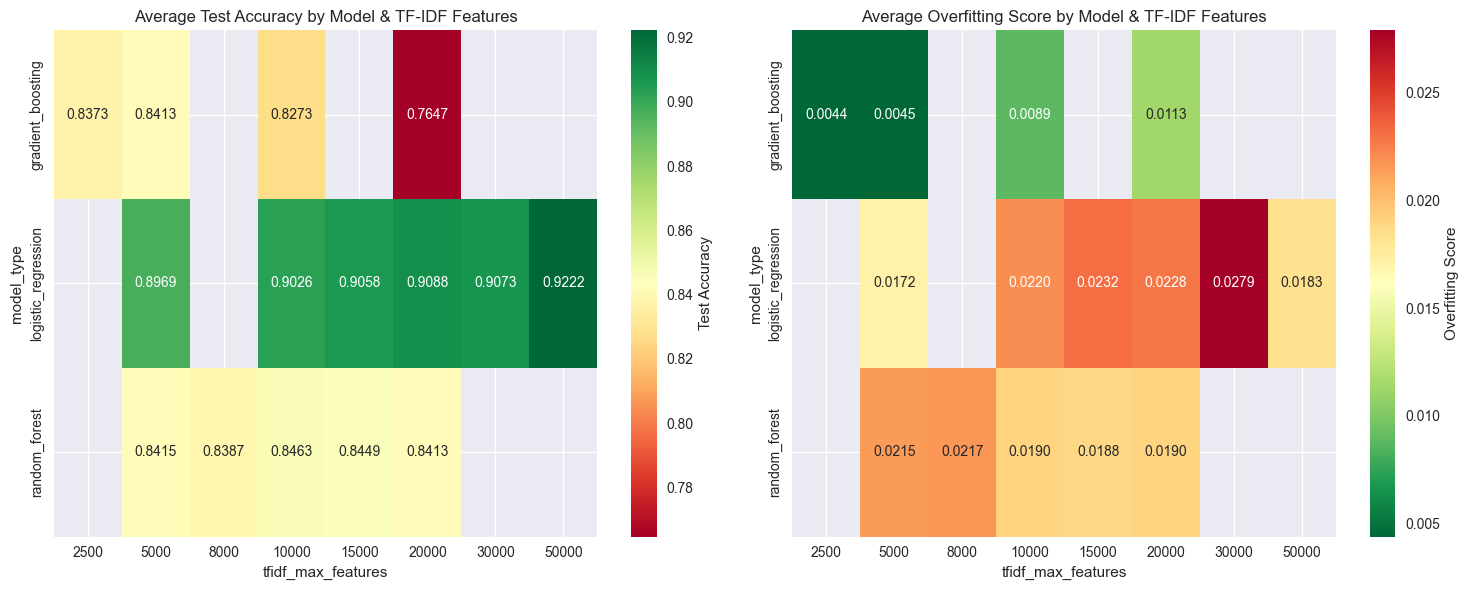


🎯 RECOMMENDATIONS:
🏆 Best Overall Performance:
   Model: logistic_regression
   Accuracy: 0.9222
   F1 Score: 0.9222
   TF-IDF Features: 50000
   Run: accuracy_optimized_configuration_results_20250819_042440.json

⚡ Most Efficient Model:
   Model: logistic_regression
   Accuracy: 0.9076
   Training Time: 9.01s
   Efficiency: 0.100733

🔧 Optimal TF-IDF Settings:
   Best max_features: 50000 (Avg Accuracy: 0.9222)


In [17]:
def create_summary_dashboard(df):
    """
    Tạo dashboard tổng hợp performance
    """
    # Overall statistics
    print("📊 PERFORMANCE SUMMARY DASHBOARD")
    print("=" * 50)
    
    summary_stats = df.groupby('model_type').agg({
        'test_accuracy': ['mean', 'max', 'min', 'std'],
        'f1_macro': ['mean', 'max', 'min', 'std'],
        'overfitting_score': ['mean', 'min', 'max', 'std'],
        'training_time': ['mean', 'min', 'max', 'std']
    }).round(4)
    
    print("\n📈 Overall Model Performance:")
    print(summary_stats)
    
    # Create heatmap of average performance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Performance heatmap
    perf_data = df.pivot_table(values='test_accuracy', 
                              index='model_type', 
                              columns='tfidf_max_features', 
                              aggfunc='mean')
    
    sns.heatmap(perf_data, annot=True, fmt='.4f', cmap='RdYlGn', 
                ax=axes[0], cbar_kws={'label': 'Test Accuracy'})
    axes[0].set_title('Average Test Accuracy by Model & TF-IDF Features')
    
    # Overfitting heatmap
    overfit_data = df.pivot_table(values='overfitting_score', 
                                 index='model_type', 
                                 columns='tfidf_max_features', 
                                 aggfunc='mean')
    
    sns.heatmap(overfit_data, annot=True, fmt='.4f', cmap='RdYlGn_r', 
                ax=axes[1], cbar_kws={'label': 'Overfitting Score'})
    axes[1].set_title('Average Overfitting Score by Model & TF-IDF Features')
    
    plt.tight_layout()
    plt.show()
    
    # Recommendations
    print("\n🎯 RECOMMENDATIONS:")
    print("=" * 30)
    
    # Best overall performer
    best_overall = df.loc[df['test_accuracy'].idxmax()]
    print(f"🏆 Best Overall Performance:")
    print(f"   Model: {best_overall['model_type']}")
    print(f"   Accuracy: {best_overall['test_accuracy']:.4f}")
    print(f"   F1 Score: {best_overall['f1_macro']:.4f}")
    print(f"   TF-IDF Features: {best_overall['tfidf_max_features']}")
    print(f"   Run: {best_overall['filename']}")
    
    # Most efficient (best accuracy per training time)
    df['efficiency'] = df['test_accuracy'] / df['training_time']
    most_efficient = df.loc[df['efficiency'].idxmax()]
    print(f"\n⚡ Most Efficient Model:")
    print(f"   Model: {most_efficient['model_type']}")
    print(f"   Accuracy: {most_efficient['test_accuracy']:.4f}")
    print(f"   Training Time: {most_efficient['training_time']:.2f}s")
    print(f"   Efficiency: {most_efficient['efficiency']:.6f}")
    
    # Best parameter recommendations
    print(f"\n🔧 Optimal TF-IDF Settings:")
    tfidf_performance = df.groupby('tfidf_max_features')['test_accuracy'].mean().sort_values(ascending=False)
    best_tfidf = tfidf_performance.index[0]
    print(f"   Best max_features: {best_tfidf} (Avg Accuracy: {tfidf_performance.iloc[0]:.4f})")

create_summary_dashboard(df_comprehensive)

## 10. Real-time Monitoring Setup

In [10]:
def setup_monitoring():
    """
    Setup function để monitor các file report mới
    """
    print("🔍 REAL-TIME MONITORING SETUP")
    print("=" * 40)
    
    print("📁 Current monitoring directory: ../src/reports/")
    print("📊 Files being monitored:")
    
    reports_dir = "../src/reports/"
    json_files = glob.glob(os.path.join(reports_dir, "*.json"))
    
    for i, file_path in enumerate(sorted(json_files), 1):
        filename = os.path.basename(file_path)
        file_time = datetime.fromtimestamp(os.path.getmtime(file_path))
        print(f"   {i:2d}. {filename} (Modified: {file_time.strftime('%Y-%m-%d %H:%M:%S')})")
    
    print(f"\n✅ Total {len(json_files)} files in monitoring")
    
    print("\n🔄 To refresh analysis with new data, run:")
    print("   1. Re-run section 2 (Auto-Load All Report Files)")
    print("   2. Re-run section 3 (Extract Performance and Parameter Data)")
    print("   3. Re-run any analysis sections you want to update")
    
    # Save current analysis results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"../output/performance_analysis_{timestamp}.csv"
    df_comprehensive.to_csv(output_file, index=False)
    print(f"\n💾 Analysis results saved to: {output_file}")

setup_monitoring()

🔍 REAL-TIME MONITORING SETUP
📁 Current monitoring directory: ../src/reports/
📊 Files being monitored:
    1. accuracy_optimized_configuration_results_20250819_042440.json (Modified: 2025-08-19 04:24:40)
    2. balanced_configuration_results_20250819_024601.json (Modified: 2025-08-19 02:46:01)
    3. balanced_configuration_results_20250819_024930.json (Modified: 2025-08-19 02:49:30)
    4. balanced_configuration_results_20250819_030058.json (Modified: 2025-08-19 03:00:58)
    5. balanced_configuration_results_20250819_030303.json (Modified: 2025-08-19 03:03:03)
    6. balanced_configuration_results_20250819_030547.json (Modified: 2025-08-19 03:20:07)
    7. balanced_configuration_results_20250819_030912.json (Modified: 2025-08-19 03:09:12)
    8. balanced_configuration_results_20250819_031300.json (Modified: 2025-08-19 03:13:00)
    9. balanced_configuration_results_20250819_031626.json (Modified: 2025-08-19 03:16:26)
   10. balanced_configuration_results_20250819_031916.json (Modified:

## 11. Quick Refresh Function

In [11]:
def quick_refresh_analysis():
    """
    Quick function để refresh toàn bộ analysis
    """
    print("🔄 REFRESHING ANALYSIS...")
    
    # Reload data
    global all_reports, df_comprehensive
    all_reports = load_all_reports()
    df_comprehensive = extract_comprehensive_data(all_reports)
    df_comprehensive['datetime'] = pd.to_datetime(df_comprehensive['timestamp'])
    
    print("\n📊 Updated Analysis Results:")
    print(f"   Total runs analyzed: {len(df_comprehensive)}")
    print(f"   Time range: {df_comprehensive['timestamp'].min()} to {df_comprehensive['timestamp'].max()}")
    print(f"   Models: {', '.join(df_comprehensive['model_type'].unique())}")
    
    # Quick summary of latest results
    latest_results = df_comprehensive.loc[df_comprehensive.groupby('model_type')['datetime'].idxmax()]
    print("\n🕒 Latest Results by Model:")
    for _, row in latest_results.iterrows():
        print(f"   {row['model_type']}: {row['test_accuracy']:.4f} accuracy ({row['filename']})")
    
    print("\n✅ Analysis refreshed! You can now run other analysis sections with updated data.")
    return df_comprehensive

# Uncomment the line below to refresh analysis
# df_comprehensive = quick_refresh_analysis()